# Import Modules

In [50]:
import datetime
import time
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Datasets / EDA

### Use of three datasets:
- Stock Dataset\
Available data, from 2021-09-30 to 2022-09-29
- Macro Economics Dataset\
Available data, from 1980-11-01 to 2022-05-01
- Twitter data\
Available data, from 2021-09-30 to 2022-09-29

The available data range that is available from these three datasets: 10/1/2021 - 5/31/2022.
So each dataset will be filtered within this date range.

## Stock Dataset

In [51]:
# https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
data_stock_src = pd.read_csv('Data/stock_data.csv')
data_stock_src

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [52]:
# Check what is the date range of available data
print(data_stock_src['Date'].min())
print(data_stock_src['Date'].max())

2021-09-30
2022-09-29


In [53]:
# Check if there is any missing data!
data_stock_src.isna().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Stock Name    0
dtype: int64

We need to do some data clean-up and filtering for this **Stock data**:
- Only interested in Tesla data, so we need to filter all rows only for 'TSLA'
- Remove 'Close' column and rename 'Adj Close' to 'value' and other columns to lower case.
- Need to filter the rows only for dates from 10/1/2021 to 5/31/2022 because our twitter data only has this time period
- Need to create a new column called 'target' and populate with value of 1 (means stock value go up from previous day) or 0 (means stock value go down from previous day) 

In [54]:
data_stock = data_stock_src[data_stock_src['Stock Name'] == "TSLA"]
data_stock = data_stock[['Date', 'Adj Close', 'Open', 'High', 'Low', 'Volume']]
data_stock = data_stock.rename(columns={"Date": "date", "Adj Close": "value", "Open": "open",
                                        "High": "high", "Low": "low", "Volume": "volume"})
data_stock['diff'] = data_stock['value'] - data_stock['value'].shift(1)
data_stock['target'] = data_stock['diff'].apply(lambda x: 1 if x > 0 else 0)
data_stock['date'] = pd.to_datetime(data_stock['date']).dt.date
data_stock = data_stock.drop("diff", axis=1)
data_stock = data_stock[(data_stock['date']>=datetime.date(2021,10,1)) & (data_stock['date']<=datetime.date(2022,5,31))] 
data_stock = data_stock.set_index('date')

data_stock

,value,open,high,low,volume,target
date,,,,,,
2021-10-01,258.406677,259.466675,260.260010,254.529999,51094200,0
2021-10-04,260.510010,265.500000,268.989990,258.706665,91449900,1
2021-10-05,260.196655,261.600006,265.769989,258.066681,55297800,0
2021-10-06,260.916656,258.733337,262.220001,257.739990,43898400,1
2021-10-07,264.536682,261.820007,268.333344,261.126678,57587400,1
...,...,...,...,...,...,...
2022-05-24,209.386673,217.843338,217.973328,206.856674,89092500,0
2022-05-25,219.600006,207.949997,223.106674,207.669998,92139300,1
2022-05-26,235.910004,220.473328,239.556671,217.886673,106003200,1


## Macro Economics Dataset

In [55]:
# https://www.kaggle.com/datasets/sarthmirashi07/us-macroeconomic-data
data_eco_source = pd.read_csv('Data/US_macroeconomics.csv')
data_eco_source

,date,CPI,Mortgage_rate,Unemp_rate,NASDAQ,disposable_income,Personal_consumption_expenditure,personal_savings
0,1980-11-01,85.600,14.2050,7.5,200.685556,4976.5,1826.8,11.6
1,1980-12-01,86.400,14.7900,7.2,198.398636,4999.8,1851.7,11.4
2,1981-01-01,87.200,14.9040,7.5,198.817619,4980.4,1870.0,10.9
3,1981-02-01,88.000,15.1325,7.4,194.852105,4965.0,1884.2,10.8
4,1981-03-01,88.600,15.4000,7.4,203.593182,4979.0,1902.9,10.8
...,...,...,...,...,...,...,...,...
494,2022-01-01,281.933,3.4450,4.0,14531.377500,15163.5,16543.3,5.8
495,2022-02-01,284.182,3.7625,3.8,13898.727895,15173.6,16635.8,5.8
496,2022-03-01,287.708,4.1720,3.6,13623.263043,15119.6,16831.2,5.3
497,2022-04-01,288.663,4.9825,3.6,13394.163000,15154.4,16911.2,5.2


In [56]:
# Check what is the date range of available data
print(data_eco_source['date'].min())
print(data_eco_source['date'].max())

1980-11-01
2022-05-01


In [57]:
# Check if there is any missing data!
data_eco_source.isna().sum()

date                                0
CPI                                 0
Mortgage_rate                       0
Unemp_rate                          0
NASDAQ                              0
disposable_income                   0
Personal_consumption_expenditure    0
personal_savings                    0
dtype: int64

We need to do some data clean-up and filtering for this **Macro Economics** data:
- Need to filter the rows only for dates from 10/1/2021 to 5/31/2022 because our twitter data only has this time period
- Drop un-needed columns, rename some of columns and make it lower case
- Since the data is monthly and we need to join this data with other dataset, we need to duplicate the data into daily data for the same month

In [58]:
# date initially is a string, convert into a date datatype
data_eco_source['date'] = pd.to_datetime(data_eco_source['date']).dt.date

# filter only rows that we are interested
data_eco_source = data_eco_source[(data_eco_source['date']>=datetime.date(2021,10,1)) & (data_eco_source['date']<=datetime.date(2022,5,31))] 

In [10]:
data_eco_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 491 to 498
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              8 non-null      object 
 1   CPI                               8 non-null      float64
 2   Mortgage_rate                     8 non-null      float64
 3   Unemp_rate                        8 non-null      float64
 4   NASDAQ                            8 non-null      float64
 5   disposable_income                 8 non-null      float64
 6   Personal_consumption_expenditure  8 non-null      float64
 7   personal_savings                  8 non-null      float64
dtypes: float64(7), object(1)
memory usage: 576.0+ bytes


In [59]:
data_eco_source = data_eco_source.drop("NASDAQ", axis=1)
data_eco_source = data_eco_source.rename(columns={"CPI": "cpi", "Mortgage_rate": "mortgage_rate", 
                                                  "Unemp_rate": "unemp_rate", "Personal_consumption_expenditure": "personal_cons_exp"})
data_eco_source

,date,cpi,mortgage_rate,unemp_rate,disposable_income,personal_cons_exp,personal_savings
491,2021-10-01,276.590,3.0675,4.6,15472.4,16309.5,7.5
492,2021-11-01,278.524,3.0675,4.2,15470.8,16390.9,7.6
493,2021-12-01,280.126,3.0980,3.9,15442.7,16242.3,8.7
494,2022-01-01,281.933,3.4450,4.0,15163.5,16543.3,5.8
495,2022-02-01,284.182,3.7625,3.8,15173.6,16635.8,5.8
496,2022-03-01,287.708,4.1720,3.6,15119.6,16831.2,5.3
497,2022-04-01,288.663,4.9825,3.6,15154.4,16911.2,5.2
498,2022-05-01,291.474,5.2300,3.6,15144.8,16954.5,5.4


In [60]:
# me = macro economics
data_eco = pd.DataFrame()
for index, row in data_eco_source.iterrows():
    # Transpose the columns become rows!
    tmp = pd.DataFrame(row).transpose()
    days_in_month = pd.to_datetime(tmp['date']).dt.daysinmonth.item()
    month = pd.to_datetime(tmp['date']).dt.month.item()
    year = pd.to_datetime(tmp['date']).dt.year.item()

    for i in range(days_in_month):
        tmp['date'] = datetime.date(year, month, i+1)
        data_eco = pd.concat([data_eco, tmp])

data_eco = data_eco.set_index('date')

In [61]:
data_eco['cpi'] = pd.to_numeric(data_eco['cpi'])
data_eco['mortgage_rate'] = pd.to_numeric(data_eco['mortgage_rate'])
data_eco['unemp_rate'] = pd.to_numeric(data_eco['unemp_rate'])
data_eco['disposable_income'] = pd.to_numeric(data_eco['disposable_income'])
data_eco['personal_cons_exp'] = pd.to_numeric(data_eco['personal_cons_exp'])
data_eco['personal_savings'] = pd.to_numeric(data_eco['personal_savings'])

In [62]:
data_eco.head()

,cpi,mortgage_rate,unemp_rate,disposable_income,personal_cons_exp,personal_savings
date,,,,,,
2021-10-01,276.59,3.0675,4.6,15472.4,16309.5,7.5
2021-10-02,276.59,3.0675,4.6,15472.4,16309.5,7.5
2021-10-03,276.59,3.0675,4.6,15472.4,16309.5,7.5
2021-10-04,276.59,3.0675,4.6,15472.4,16309.5,7.5
2021-10-05,276.59,3.0675,4.6,15472.4,16309.5,7.5


In [63]:
# Check all data types, to make sure numeric
data_eco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 2021-10-01 to 2022-05-31
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cpi                243 non-null    float64
 1   mortgage_rate      243 non-null    float64
 2   unemp_rate         243 non-null    float64
 3   disposable_income  243 non-null    float64
 4   personal_cons_exp  243 non-null    float64
 5   personal_savings   243 non-null    float64
dtypes: float64(6)
memory usage: 13.3+ KB


## Twitter data

In [64]:
# https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
data_twitter = pd.read_csv('Data/stock_tweets.csv')
data_twitter.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [65]:
# Check what is the date range of available data
print(data_twitter['Date'].min())
print(data_twitter['Date'].max())

2021-09-30 00:06:02+00:00
2022-09-29 23:41:16+00:00


In [66]:
data_twitter.isna().sum()

Date            0
Tweet           0
Stock Name      0
Company Name    0
dtype: int64

We need to do some data clean-up and filtering for this **Twitter** data:
- Need to filter the rows only for dates from 10/1/2021 to 5/31/2022 because our twitter data only has this time period
- rename some of columns and make it lower case
- Clean-up some un-wanted character or text such as \n, &amp;, etc.

In [67]:
data_twitter = data_twitter[data_twitter['Stock Name'] == "TSLA"]
data_twitter = data_twitter[['Date', 'Tweet']]
data_twitter = data_twitter.rename(columns={"Date": "date", "Tweet": "tweet"})

data_twitter['tweet'] = data_twitter['tweet'].str.replace('\n', ' ', regex=False)
data_twitter['tweet'] = data_twitter['tweet'].str.replace('&amp;', '&', regex=False)
data_twitter['tweet'] = data_twitter['tweet'].str.replace('&gt', '', regex=False)
data_twitter['tweet'] = data_twitter['tweet'].str.replace('&lt', '', regex=False)

data_twitter['date'] = pd.to_datetime(data_twitter['date']).dt.date
data_twitter = data_twitter[(data_twitter['date']>=datetime.date(2021,10,1)) & (data_twitter['date']<=datetime.date(2022,5,31))]  

data_twitter = data_twitter.sort_values(by=['date'])
data_twitter

,date,tweet
37331,2021-10-01,Pelosi still scrambling to find enough votes t...
37262,2021-10-01,WOW 🤯 Record high markedshare of BEVs in new p...
37263,2021-10-01,Tech focused firms dominate the top 10 by mark...
37264,2021-10-01,When is the last time Max Pain on a Friday was...
37265,2021-10-01,Next week is huge for tesla. It’s all coming t...
...,...,...
9987,2022-05-31,"Premarket plan ☀️ $SPX small gap down, if it ..."
9988,2022-05-31,9-5 jobs don’t suck. Your attitude does. ...
9989,2022-05-31,Mizuho: Giga Shanghai Will Act as a Q2 Headwin...
9982,2022-05-31,"Back in at $750. 1,000 again. $TSLA"


## Twitter data: Populate Sentiment Analysis
### Use Roberta Pretrained Model

In [68]:
roberta_model_name = f"cardiffnlp/twitter-roberta-base-sentiment" 
tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

In [69]:
# define a function to return sentiment rating scores
def sentiment_rate(prefix, text):
    tokenized_text = tokenizer(text, return_tensors='pt')
    output = model(**tokenized_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores = {
        prefix + 'negative': scores[0],  # 0-1 where 1 means very negative
        prefix + 'neutral' : scores[1],  # 0-1 where 1 means very neutral
        prefix + 'positive': scores[2]   # 0-1 where 1 means very positive
    }
    return scores

In [70]:
# do some testing
# the result seems to be good for us to use for the score of user sentiment

result = sentiment_rate("test_", "sold mine and put it into amzn. tsla calls haven’t been the play this year")
print(result)

result = sentiment_rate("test_", "It's a good deal, bought more tsla this month")
print(result)

{'test_negative': 0.67204547, 'test_neutral': 0.3066207, 'test_positive': 0.021333795}
{'test_negative': 0.0015362375, 'test_neutral': 0.02422222, 'test_positive': 0.9742415}


In [71]:
# Let's go through the entire rows and generate the sentiment scores
# We will average the scores for the same day and dataset is already ordered by date

results = {}
i = 0

for index, row in data_twitter.iterrows():
    try:
        tweet = row['tweet']
        date = row['date']
        res = sentiment_rate("tw_", tweet)
        tmp_res = {**res}

        tmp_res['date'] = date
        results[i] = tmp_res
            
        i = i + 1
        
        if i % 500 == 0:
            print(f'Processed row: {i}')

    except RuntimeError:
        print(f'FAIL processing row on index: {index}')
        
print(f'Processed row: {i}')

Processed row: 500
Processed row: 1000
Processed row: 1500
Processed row: 2000
Processed row: 2500
Processed row: 3000
Processed row: 3500
Processed row: 4000
Processed row: 4500
Processed row: 5000
Processed row: 5500
Processed row: 6000
Processed row: 6500
Processed row: 7000
Processed row: 7500
Processed row: 8000
Processed row: 8500
Processed row: 9000
Processed row: 9500
Processed row: 10000
Processed row: 10500
Processed row: 11000
Processed row: 11500
Processed row: 12000
Processed row: 12500
Processed row: 13000
Processed row: 13500
Processed row: 14000
Processed row: 14500
Processed row: 15000
Processed row: 15500
Processed row: 16000
Processed row: 16500
Processed row: 17000
Processed row: 17500
Processed row: 18000
Processed row: 18500
Processed row: 19000
Processed row: 19500
Processed row: 20000
Processed row: 20500
Processed row: 21000
Processed row: 21500
Processed row: 22000
Processed row: 22500
Processed row: 23000
Processed row: 23500
Processed row: 24000
Processed ro

In [72]:
# Save into a file, so next time we can re-use it, rather than re-run again since it's taking long time.
results_df = pd.DataFrame(results).T

# Disable this if we don't want to replace existing file!
results_df.to_csv("Data/sentiment_result_twitter.csv")

In [73]:
results_df

,tw_negative,tw_neutral,tw_positive,date
0,0.552253,0.422978,0.024769,2021-10-01
1,0.001438,0.035652,0.962909,2021-10-01
2,0.004863,0.566292,0.428845,2021-10-01
3,0.008629,0.161029,0.830342,2021-10-01
4,0.000892,0.01813,0.980979,2021-10-01
...,...,...,...,...
27388,0.005906,0.394312,0.599782,2022-05-31
27389,0.156927,0.412268,0.430805,2022-05-31
27390,0.005458,0.411384,0.583158,2022-05-31
27391,0.015898,0.786691,0.197411,2022-05-31


In [74]:
# To save time, we can read our previously saved result! So we can skip several steps above!

In [75]:
# Read from saved CSV file. 
data_tweet = pd.read_csv("Data/sentiment_result_twitter.csv")
data_tweet['date'] = pd.to_datetime(data_tweet['date']).dt.date
data_tweet = data_tweet.drop("Unnamed: 0", axis=1)

In [76]:
# Calculate Polarity: Score will be from -1 to 1
# Polarity: The overall sentiment conveyed by a particular text
data_tweet["tw_polarity"] = np.tanh(data_tweet["tw_positive"] - data_tweet["tw_negative"])

In [77]:
data_tweet = data_tweet.groupby(['date']).mean()

In [78]:
data_tweet

,tw_negative,tw_neutral,tw_positive,tw_polarity
date,,,,
2021-10-01,0.171916,0.416234,0.411851,0.195400
2021-10-02,0.097741,0.352222,0.550037,0.365543
2021-10-03,0.142144,0.317479,0.540377,0.323663
2021-10-04,0.197946,0.463866,0.338188,0.113217
2021-10-05,0.218976,0.402831,0.378192,0.124566
...,...,...,...,...
2022-05-27,0.131376,0.375235,0.493389,0.298510
2022-05-28,0.187265,0.410875,0.401860,0.172245
2022-05-29,0.120746,0.409755,0.469499,0.290526


## Combine Dataset: Stock Data, Macro Economics, and Twitter Feed

In [79]:
df = pd.concat([data_stock, data_eco], axis=1, join="inner")
df = pd.concat([df, data_tweet], axis=1, join="inner")

In [80]:
df

,value,open,high,low,volume,target,cpi,mortgage_rate,unemp_rate,disposable_income,personal_cons_exp,personal_savings,tw_negative,tw_neutral,tw_positive,tw_polarity
date,,,,,,,,,,,,,,,,
2021-10-01,258.406677,259.466675,260.260010,254.529999,51094200,0,276.590,3.0675,4.6,15472.4,16309.5,7.5,0.171916,0.416234,0.411851,0.195400
2021-10-04,260.510010,265.500000,268.989990,258.706665,91449900,1,276.590,3.0675,4.6,15472.4,16309.5,7.5,0.197946,0.463866,0.338188,0.113217
2021-10-05,260.196655,261.600006,265.769989,258.066681,55297800,0,276.590,3.0675,4.6,15472.4,16309.5,7.5,0.218976,0.402831,0.378192,0.124566
2021-10-06,260.916656,258.733337,262.220001,257.739990,43898400,1,276.590,3.0675,4.6,15472.4,16309.5,7.5,0.156518,0.434766,0.408716,0.204950
2021-10-07,264.536682,261.820007,268.333344,261.126678,57587400,1,276.590,3.0675,4.6,15472.4,16309.5,7.5,0.125951,0.429613,0.444436,0.256894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,209.386673,217.843338,217.973328,206.856674,89092500,0,291.474,5.2300,3.6,15144.8,16954.5,5.4,0.261293,0.437000,0.301707,0.024150
2022-05-25,219.600006,207.949997,223.106674,207.669998,92139300,1,291.474,5.2300,3.6,15144.8,16954.5,5.4,0.211594,0.452207,0.336199,0.102189
2022-05-26,235.910004,220.473328,239.556671,217.886673,106003200,1,291.474,5.2300,3.6,15144.8,16954.5,5.4,0.123620,0.441194,0.435185,0.262619


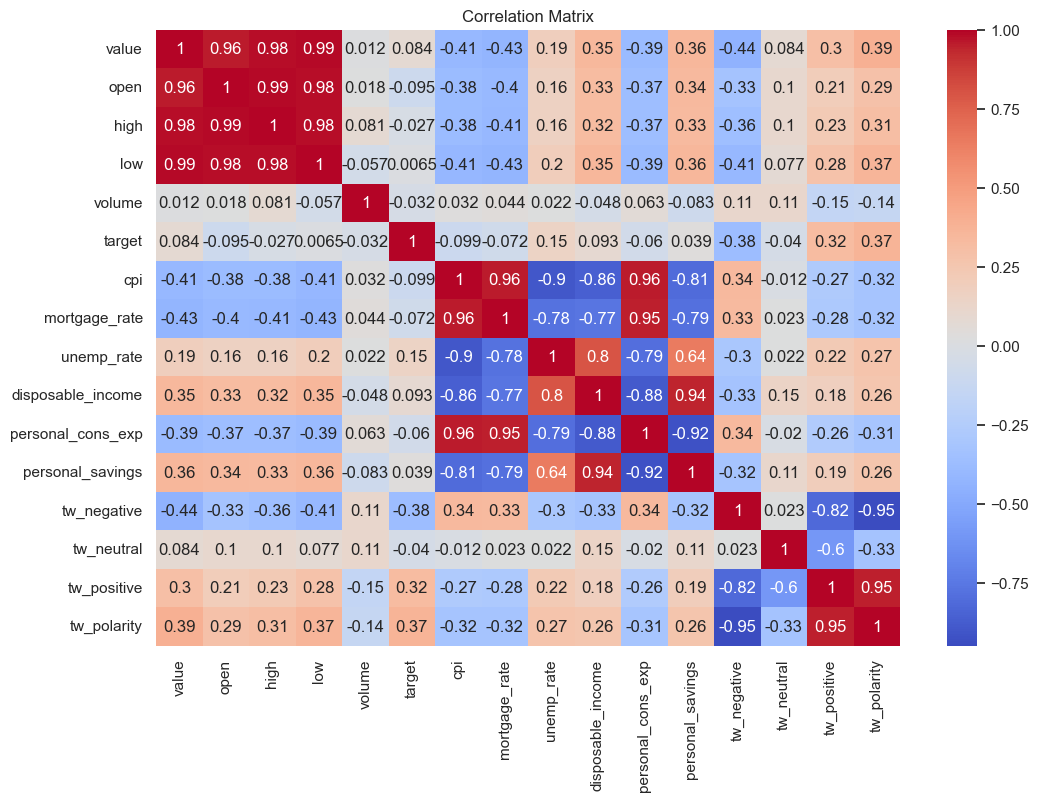

In [81]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

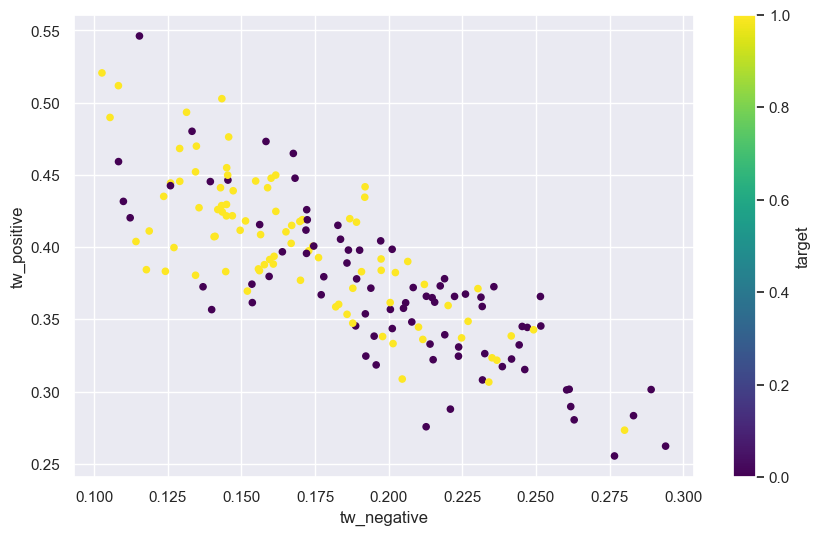

In [82]:
# Target: 1=Stock Value Up, 0=Stock Value Down
df.plot.scatter(x='tw_negative', y='tw_positive', c='target', cmap="viridis"); 

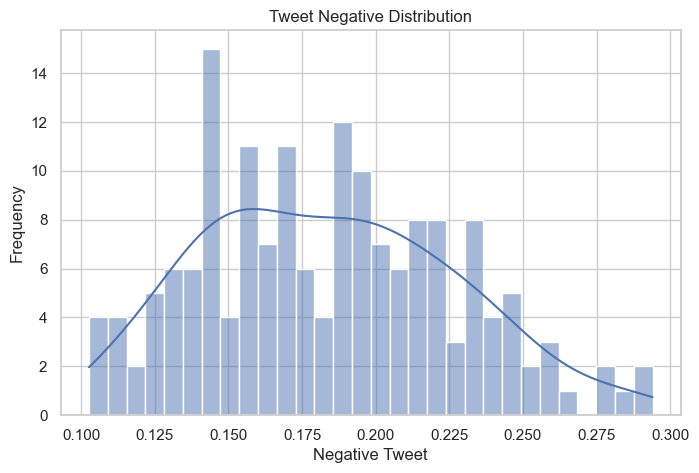

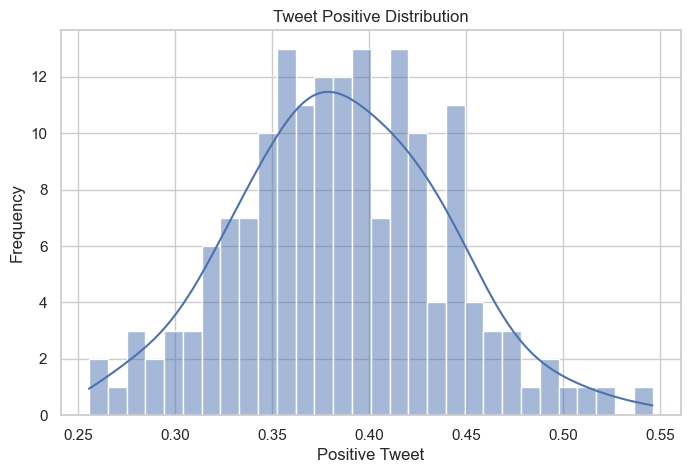

In [83]:
# Set plot style
sns.set(style="whitegrid")

# Plot the distribution of negative distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['tw_negative'], bins=30, kde=True)
plt.title('Tweet Negative Distribution')
plt.xlabel('Negative Tweet')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of positive distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['tw_positive'], bins=30, kde=True)
plt.title('Tweet Positive Distribution')
plt.xlabel('Positive Tweet')
plt.ylabel('Frequency')
plt.show()


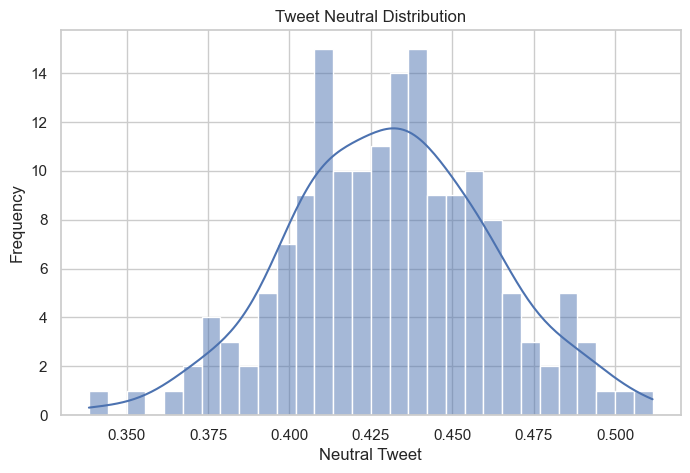

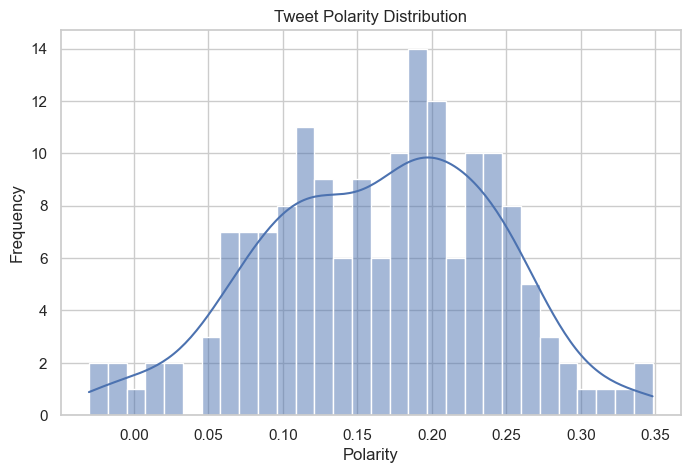

In [84]:
# Plot the distribution of positive distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['tw_neutral'], bins=30, kde=True)
plt.title('Tweet Neutral Distribution')
plt.xlabel('Neutral Tweet')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of polarity distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['tw_polarity'], bins=30, kde=True)
plt.title('Tweet Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

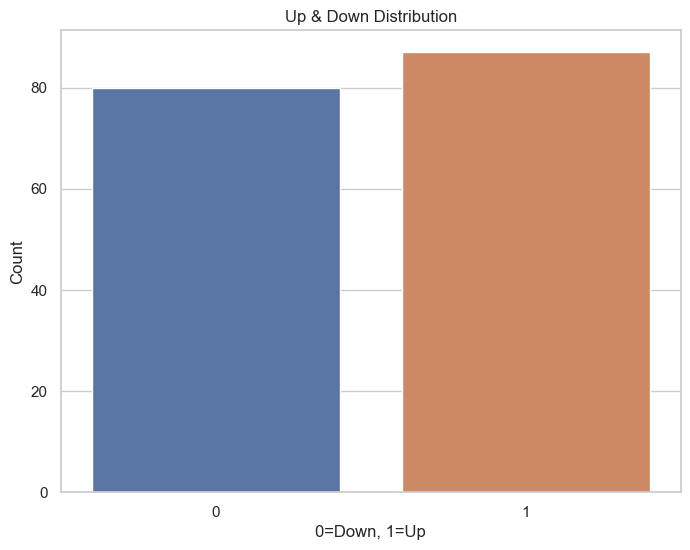

In [85]:
# Plot the count of target variable 'y'
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Up & Down Distribution')
plt.xlabel('0=Down, 1=Up')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Stock Price / Value')

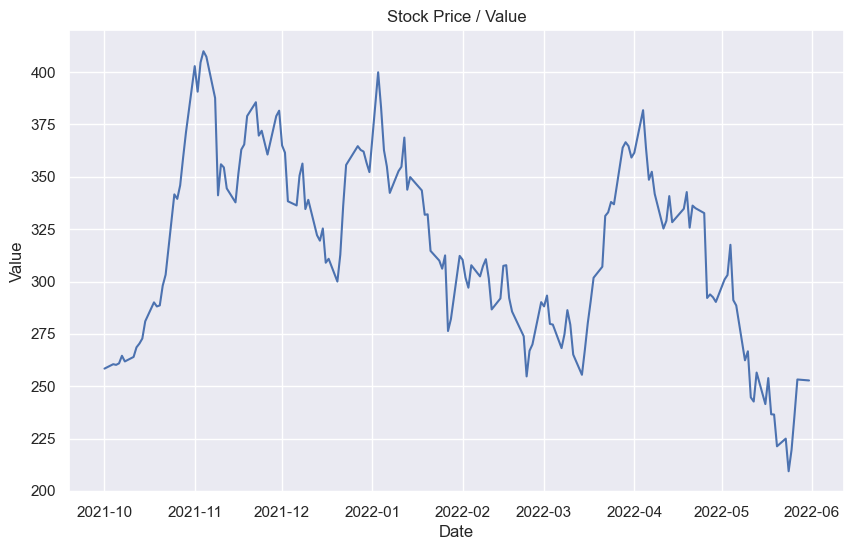

In [86]:
# Let's look at the stock price chart quick!
sns.set_theme(rc={'figure.figsize':(10, 6)})
ax = sns.lineplot(x='date', y='value', data=df)
ax.set(xlabel='Date', ylabel='Value')
ax.set_title('Stock Price / Value')

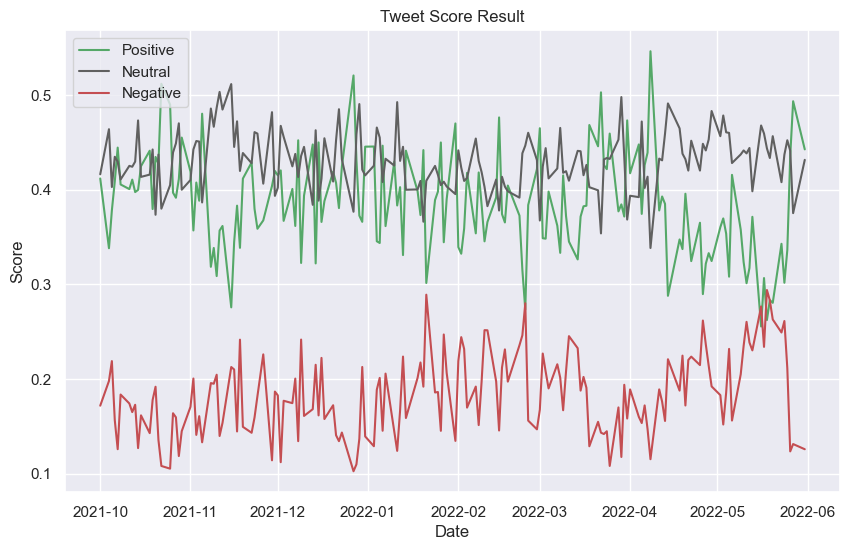

In [87]:
# Plot Tweet Score: Positive, Neutral, and Negative (all add up to 1)
# Notice that 'positive' is not that high and almost about the same score as 'neutral' 
# We don't have balance data and it will be great if we have stronger positive sentiment
plt.plot(df['tw_positive'], color='g')
plt.plot(df['tw_neutral'], color='#606060')
plt.plot(df['tw_negative'], color='r')
plt.title('Tweet Score Result')
plt.ylabel('Score')
plt.xlabel('Date')
plt.legend(['Positive', 'Neutral', 'Negative'], loc='upper left')
plt.show()

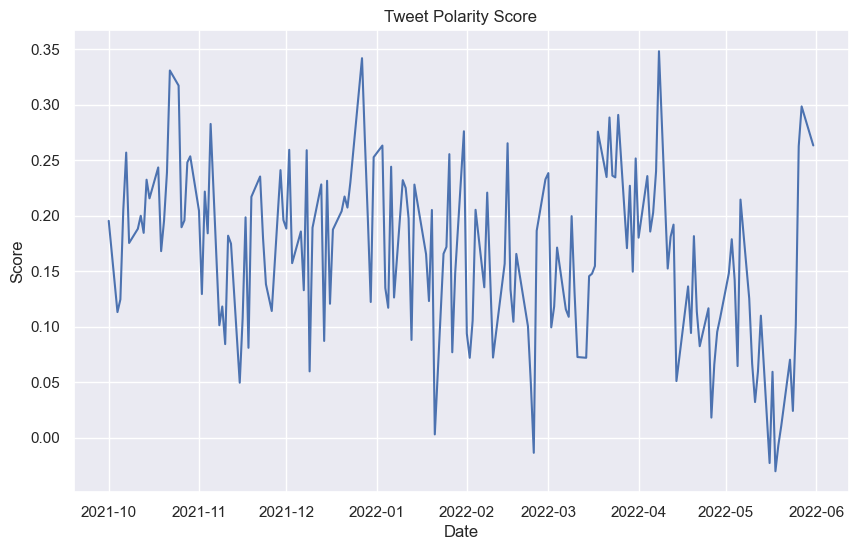

In [88]:
# Plot Tweet Polarity Score (value: -1 to 1)
# Notice that not many data that has score below 0, because mostly are positive and neutral 
# As mentioned above, this looks like we don't have balance data because neutral data pretty high
plt.plot(df['tw_polarity'], color='b')
plt.title('Tweet Polarity Score')
plt.ylabel('Score')
plt.xlabel('Date')
plt.show()

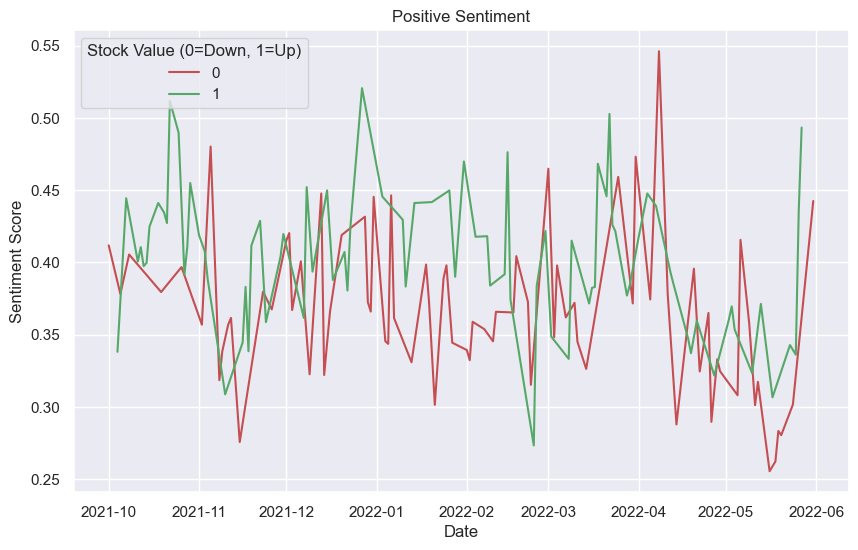

In [89]:
sns.set_theme(rc={'figure.figsize':(10, 6)})
ax = sns.lineplot(x='date', y='tw_positive', hue='target', data=df, palette=['r', 'g'])
ax.set(xlabel='Date', ylabel='Sentiment Score')
ax.set_title('Positive Sentiment')
plt.legend(title='Stock Value (0=Down, 1=Up)', loc='upper left')

# Notice: green(up or positive) is in higher score (above red) means when sentiment is positive, stock is up

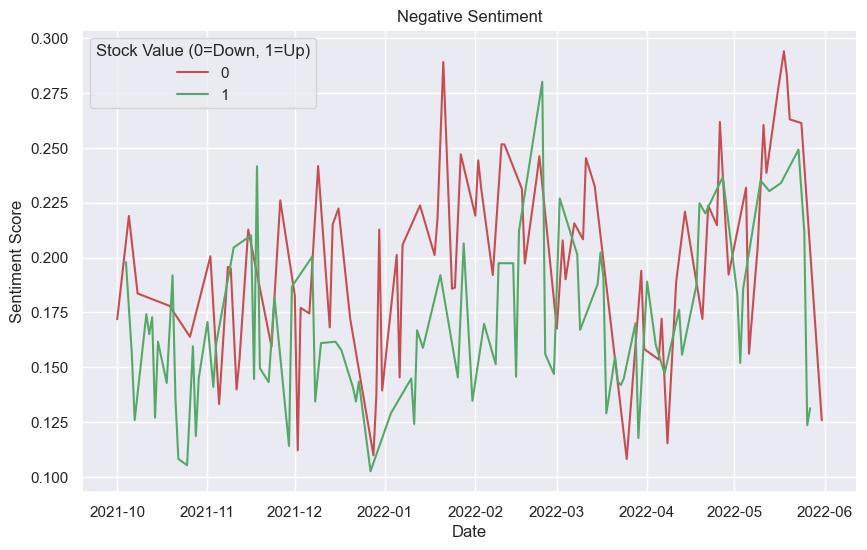

In [90]:
sns.set_theme(rc={'figure.figsize':(10, 6)})
ax = sns.lineplot(x='date', y='tw_negative', hue='target', data=df, palette=['r', 'g'])
ax.set(xlabel='Date', ylabel='Sentiment Score')
ax.set_title('Negative Sentiment')
plt.legend(title='Stock Value (0=Down, 1=Up)', loc='upper left')

# Notice red(down or negative) is in higher score (above green) means when sentiment is negative, stock is down

## Model Building

In [91]:
# Define features (X) and target (y)
# 'Target' column: 1=Up/Positive, 0=Down/Negative
X = df.drop(['target', 'value'], axis=1)
y = df['target']

# split the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [92]:
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
    ])

In [96]:
TestResult = []
def RunPipelineGridSearch(name, pipeline, params):
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, n_jobs=-1)
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    
    train_preds = grid_search.predict(X_train)
    test_preds = grid_search.predict(X_test)

    # Get the best estimator
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)

    cm = confusion_matrix(y_test, test_preds)
    sns.heatmap(cm, annot=True, fmt='g', 
                xticklabels=['Down','Up'],
                yticklabels=['Down','Up'])
    plt.ylabel('Actual', fontsize=14)
    plt.title('Confusion Matrix: ' + name, fontsize=16, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=14)
    plt.gca().xaxis.tick_top()
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.show()
    
    print( classification_report(y_test, test_preds) )
    
    # Append the results
    TestResult.append([name, best_score, train_score, test_score])

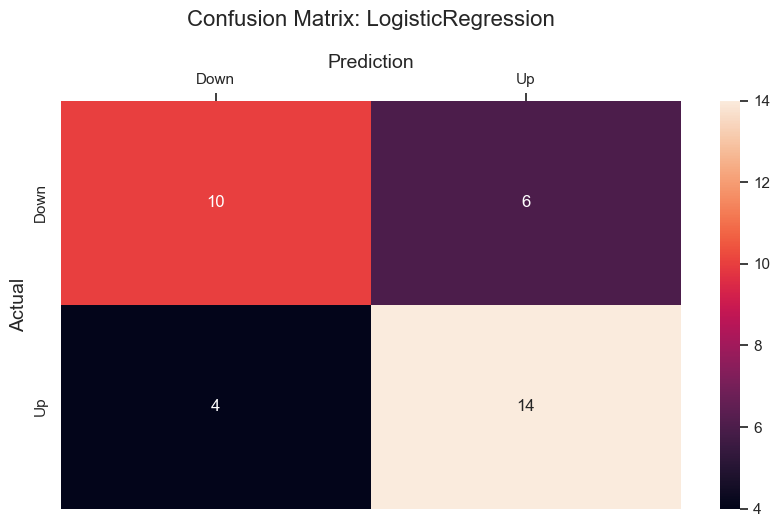

              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.70      0.78      0.74        18

    accuracy                           0.71        34
   macro avg       0.71      0.70      0.70        34
weighted avg       0.71      0.71      0.70        34



In [97]:
# Create the pipeline: GridSearchCV for Logistic Regression
pipelineGridSearchLR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=10000) )
])
paramGridSearchLR = { 'model__C': [0.1, 1, 10, 100, 200], 
                      'model__penalty': ['l1', 'l2'],               # 'elasticnet'
                      'model__solver': ['liblinear', 'saga'] }      # 'newton-cg', 'lbfgs'

RunPipelineGridSearch("LogisticRegression", pipelineGridSearchLR, paramGridSearchLR)

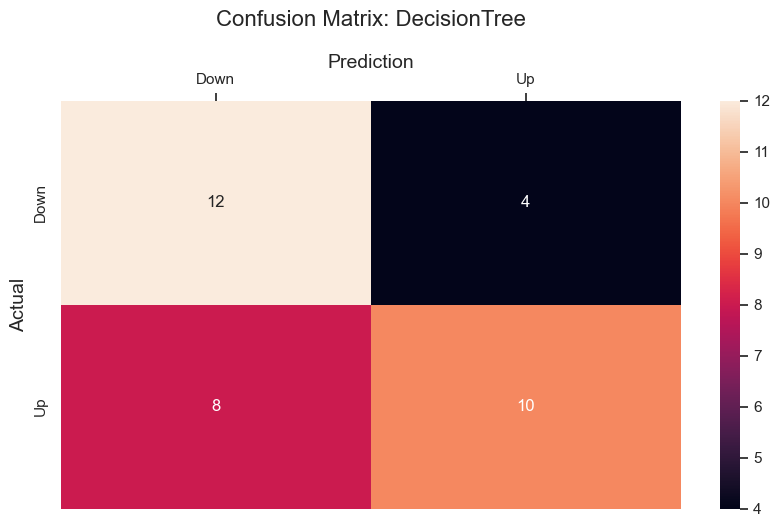

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        16
           1       0.71      0.56      0.63        18

    accuracy                           0.65        34
   macro avg       0.66      0.65      0.65        34
weighted avg       0.66      0.65      0.64        34



In [98]:
# Create the pipeline: GridSearchCV for Decision Tree
pipelineGridSearchDT = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier() )
])
paramGridSearchDT = { 'model__max_depth': [5, 10, 15, 20, 30, 40, None], 
                      'model__min_samples_split': [2, 3, 5],
                      'model__min_samples_leaf': [1, 2, 3],
                      'model__max_features': [None, 'sqrt', 'log2'],
                      'model__criterion': ['gini', 'entropy'] }

RunPipelineGridSearch("DecisionTree", pipelineGridSearchDT, paramGridSearchDT)

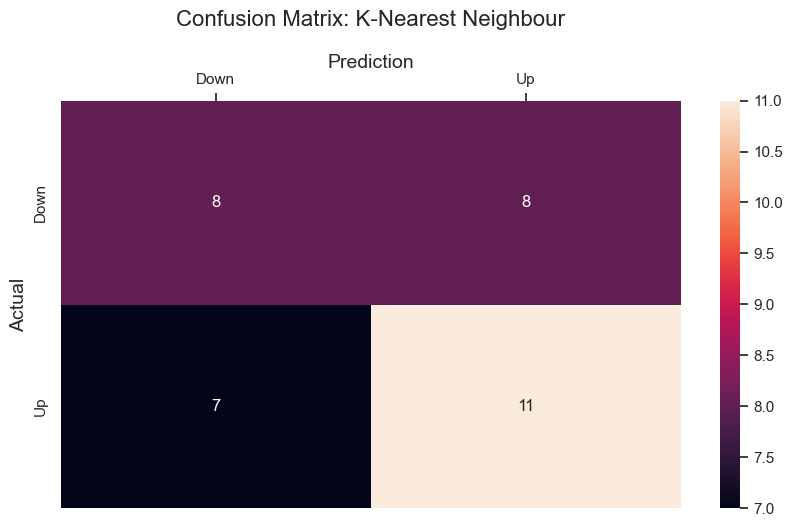

              precision    recall  f1-score   support

           0       0.53      0.50      0.52        16
           1       0.58      0.61      0.59        18

    accuracy                           0.56        34
   macro avg       0.56      0.56      0.56        34
weighted avg       0.56      0.56      0.56        34



In [99]:
# Create the pipeline: GridSearchCV for KNN
pipelineGridSearchKNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier() )
])
paramGridSearchKNN = { 'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20], 
                       'model__metric' : ['minkowski','euclidean','manhattan'],
                       'model__weights': ['uniform', 'distance'] }

RunPipelineGridSearch("K-Nearest Neighbour", pipelineGridSearchKNN, paramGridSearchKNN)

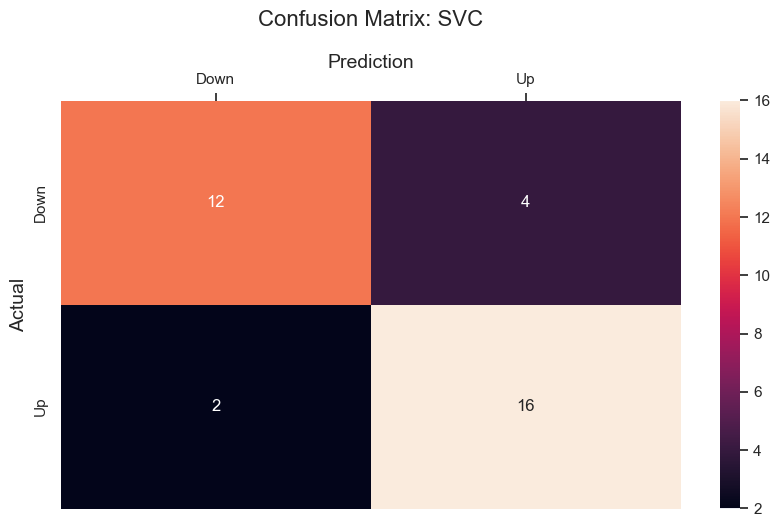

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.80      0.89      0.84        18

    accuracy                           0.82        34
   macro avg       0.83      0.82      0.82        34
weighted avg       0.83      0.82      0.82        34



In [100]:
# Create the pipeline: GridSearchCV for SVC
pipelineGridSearchSVC = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC() )
])
paramGridSearchSVC = { 'model__C': [0.1, 1, 10, 100, 1000], 
                       'model__gamma': ['scale', 'auto'],
                       'model__degree': [1, 3, 5],
                       'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid'] }

RunPipelineGridSearch("SVC", pipelineGridSearchSVC, paramGridSearchSVC)

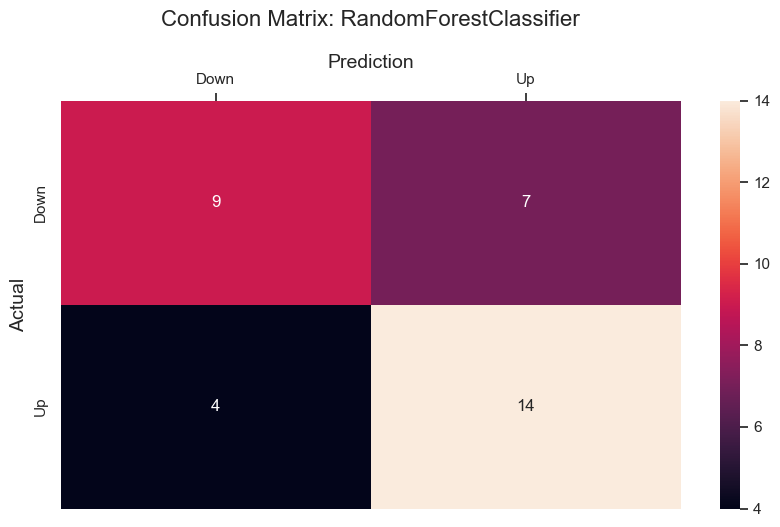

              precision    recall  f1-score   support

           0       0.69      0.56      0.62        16
           1       0.67      0.78      0.72        18

    accuracy                           0.68        34
   macro avg       0.68      0.67      0.67        34
weighted avg       0.68      0.68      0.67        34



In [101]:
# Create the pipeline: GridSearchCV for RandomForestClassifier
pipelineGridSearchRF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier() )
])
paramGridSearchRF = { 'model__n_estimators': [50, 75, 100, 150], 
                      'model__max_depth': [5, 10, 15, 25, None], 
                      'model__min_samples_leaf': [1, 3, 5],  
                      'model__min_samples_split': [2, 4, 6],
                      'model__max_leaf_nodes': [3, 6, 9, None], 
                      'model__criterion': ['gini', 'entropy', 'log_loss'] }

RunPipelineGridSearch("RandomForestClassifier", pipelineGridSearchRF, paramGridSearchRF)

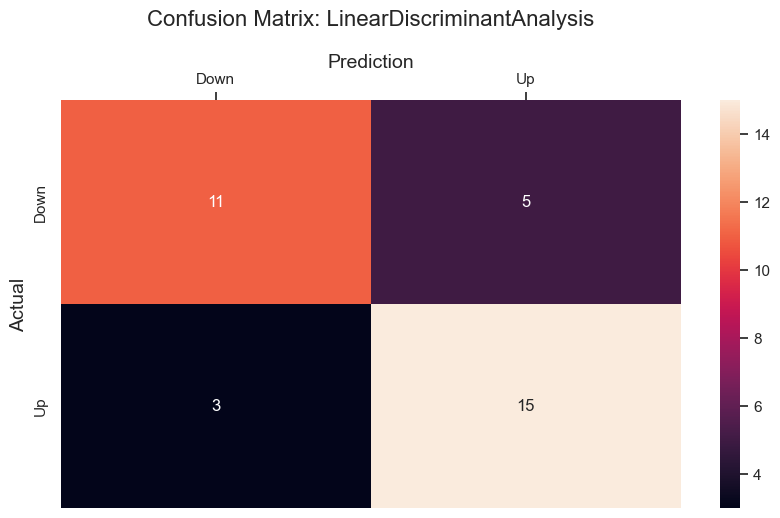

              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.75      0.83      0.79        18

    accuracy                           0.76        34
   macro avg       0.77      0.76      0.76        34
weighted avg       0.77      0.76      0.76        34



In [102]:
# Create the pipeline: GridSearchCV for LinearDiscriminantAnalysis
pipelineGridSearchLDA = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearDiscriminantAnalysis() )
])
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
paramGridSearchLDA = { 'model__solver': ['svd', 'lsqr', 'eigen'] }

RunPipelineGridSearch("LinearDiscriminantAnalysis", pipelineGridSearchLDA, paramGridSearchLDA)

## Result

In [103]:
TestResult_df = pd.DataFrame(TestResult, columns=['Model', 'Best Score', 'Train Accuracy', 'Test Accuracy'])
TestResult_df

,Model,Best Score,Train Accuracy,Test Accuracy
0,LogisticRegression,0.744505,0.759398,0.705882
1,DecisionTree,0.681319,0.939850,0.647059
2,K-Nearest Neighbour,0.654945,0.639098,0.558824
3,SVC,0.729121,0.751880,0.823529
4,RandomForestClassifier,0.706593,0.812030,0.676471
5,LinearDiscriminantAnalysis,0.692308,0.751880,0.764706
